# Feature Engineering

In this notebook I take a look at the predictive capability of the features. I would normally generate new features here, but I found little to no relationships between the variables and the use of domain knowledge is limited due to the anonymous nature of the data set. Also I could tell during the exploratory data analysis stage, that the data would not benefit from log or absolute value transformations. I will use tools to resample the data as well as deturmine the most useful features. Also I will make sure the features are clear of problems such as multicolinearity.

### Road Map

1) See Which Features Are Worth Using <br>
2) Resample Data <br>
3) Deal With Multicolinearity <br>

In [73]:
# import libraries

# standard scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plotting
import seaborn as sns

# resampling
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss

# machine learning metrics
from sklearn.metrics import f1_score, precision_score, recall_score

# machine learning models
from sklearn.ensemble import RandomForestClassifier

# time keeping
import time

In [50]:
# import data
# Note: only use training data
train = pd.read_csv("train.csv")

train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2.238954,-1.724499,-2.151484,-2.577803,0.993668,3.565492,-1.785957,0.860122,-1.264003,1.567867,...,-0.149574,-0.049333,0.278442,0.684735,-0.219028,-0.159167,0.037920,-0.049932,3.466048,0
1,-1.315062,1.630783,0.597001,-0.038359,-0.404580,-0.965712,0.212249,0.735381,-1.267926,-0.482635,...,-0.238898,-0.946773,0.323904,0.515632,-0.713000,-0.266503,-0.017794,0.051058,1.945910,0
2,1.908801,0.021184,-2.087997,0.129310,1.161468,0.605244,-0.022371,0.180296,0.283819,-0.497766,...,0.293609,1.095842,-0.044874,-1.689517,0.106098,0.007758,0.045164,-0.053068,2.705380,0
3,1.811257,0.316556,0.316751,3.880231,0.048454,1.020163,-0.734868,0.233651,0.681423,1.146705,...,0.138869,0.700422,0.174064,0.702997,-0.212523,-0.010018,-0.017740,-0.038006,2.851284,0
4,1.358817,-1.120881,0.550266,-1.547659,-1.194950,0.275448,-1.201843,0.212889,-2.094285,1.492821,...,-0.340972,-0.636442,0.252758,-0.344160,-0.064282,-0.439622,0.062524,0.013095,3.178470,0


# 1. Deturmine Which Features are Worth Using

I need to find which features are the most useful before resampling to maximise the amount of information saved.  To find the best columns for linear models I will create some "brute force" classifiers to see exactly how well each column can perform as a predictor by itself. I will simply choose a threshold for predicting fraud and non-fraud by trying 50 thresholds and then I will see which threshold gives the best f1-score. The f1-score is the harmonic mean of precision and recall. It increases when both are high and dramatically decreases when either are low. To find the best features for tree based algorithms I will create a random forest model and find the feature importances when it is trained.

### Finding Best Columns For Linear Classification

In [70]:
# create brute force classifier
class brute_force_classifier():
    
    def __init__(self):
        self.thresholds = None
        self.best_score = None
        self.best_threshold = None
        self.direction = None
        
    # method for returning predictions
    # must set best_threshold and direction
    # or call fit method before using
    def predict(self, X):
        
        # depending on the direction, classify each point on whether it is greater then
        # or less then the best threshold
        if self.direction == "less_then":
            return [1 if point < self.best_threshold else 0 for point in X]
        elif self.direction == "greater_then": 
            return [1 if point > self.best_threshold else 0 for point in X]
        else:
            return "error"
        
        
    
    # method for finding best threshold
    def fit(self, X, y):
        
        # create 200 threshold points
        thresholds = np.linspace(X.min(), X.max(), 50)
        
        # record results for each threshold and for each direction
        results_greater_then = []
        results_less_then = []
        
        # test thresholds
        for threshold in thresholds:
            
            # set current threshold to best threshold
            self.best_threshold = threshold
            
            # iterate over both directions to test both
            for current_direction in ["less_then", "greater_then"]:
                
                # set direction
                self.direction = current_direction
            
                # get results for that threshold
                predictions = self.predict(X)
                
                # save f1 score in results
                if current_direction == "less_then":
                    results_less_then.append(f1_score(y, predictions))
                else:
                    results_greater_then.append(f1_score(y, predictions))
            
        # zip results and thresholds and then form a list from the zip
        results_thresholds = list(zip(thresholds, results_less_then, results_greater_then))
        
        # sort list in ascending order
        # based on the highest f1-score for results from either direction
        sorted_results_thresholds = sorted(results_thresholds, reverse=True, key=lambda g: max([g[1], g[2]]))
        
        # find and set the best threshold. It will be the first item of the first item in the sorted list
        self.best_threshold = sorted_results_thresholds[0][0]
        
        # find and set the best direction for than threshold using an if else statement
        if sorted_results_thresholds[0][1] >= sorted_results_thresholds[0][2]:
            self.direction = "less_then"
        
        else:
            self.direction = "greater_then"
        
            

##### This cell took 10 minutes to run

In [71]:
# get results from the brute force classifier for each column

# start timer
start = time.time()

# record results in a dictionary
results = {}

# instantiate classifier
clf = brute_force_classifier()

# iterate over each column
for col in train_resampled.columns:
    
    if col != "Class":
    
        # get X_train and y_train
        X_train = train[col]
        y_train = train["Class"]

        # fit classifier
        clf.fit(X_train, y_train)
        
        # find and save score of predictions
        predictions = clf.predict(X_train)
        results[col] = f1_score(y_train, predictions)
        print(f"Column {col} completed")
    
# end timer
end = time.time()

# display computation time
expired = round(end - start)/60
print(f"This cell too {expired} minutes to run")
    

Column V1 completed
Column V2 completed
Column V3 completed
Column V4 completed
Column V5 completed
Column V6 completed
Column V7 completed
Column V8 completed
Column V9 completed
Column V10 completed
Column V11 completed
Column V12 completed
Column V13 completed
Column V14 completed
Column V15 completed
Column V16 completed
Column V17 completed
Column V18 completed
Column V19 completed
Column V20 completed
Column V21 completed
Column V22 completed
Column V23 completed
Column V24 completed
Column V25 completed
Column V26 completed
Column V27 completed
Column V28 completed
Column Amount completed
This cell too 10.983333333333333 minutes to run


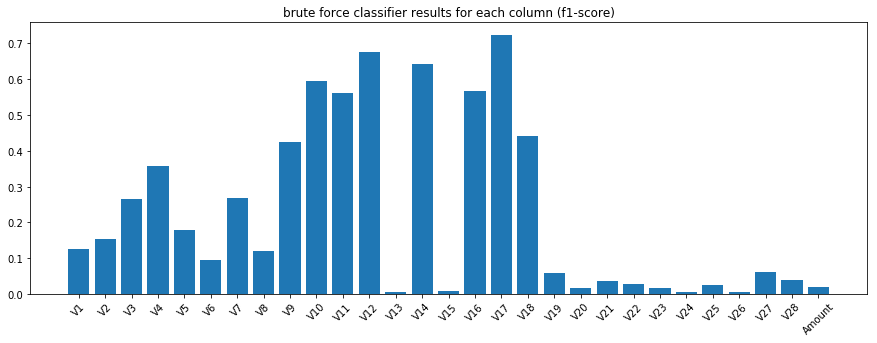

In [74]:
# plot results
results = results.items()

plt.figure(figsize=(15, 5))
plt.bar([x[0] for x in results], [x[1] for x in results])
plt.xticks(rotation=45)
plt.title("brute force classifier results for each column (f1-score)")
plt.show()

It seems all of the columns are performing well. We can see here that some columns are approaching an 75% f1-score on the training data just by themselves. To note, the columns that can produce a training f1-score of over 40% are:
* V9 
* V10
* V11
* V12
* V14
* V16
* V17
* V18

### Finding Best Columns For Tree Based Classification

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F1 Score: 0.9770580296896085


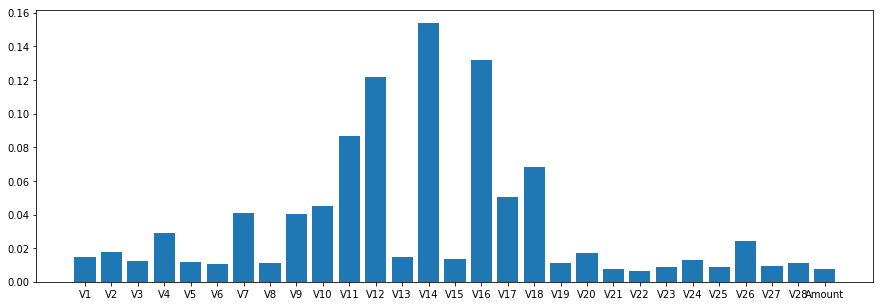

In [75]:
# Train a random forest model on the data
# and plot feature importances

# seperate X and y variables
X, y = train.drop("Class", axis=1), train.Class

# create model
rf = RandomForestClassifier()

# train model
rf.fit(X, y)

# predict and print f1-score
print("F1 Score:", f1_score(y, rf.predict(X)))

# plot feature importances
plt.figure(figsize=(15, 5))
plt.bar(X.columns, rf.feature_importances_)
plt.show()




It seems the best features for tree based algorithms are:
* V11
* V12
* V14
* V16
* V18 

Lets see if the f1-score of the classifier lowers if we only use these features.

In [76]:
# see if the f1-score of the random forest model
# increases if we only use certain features

# create a list of features to use
feats = ["V11", "V12", "V14", "V16", "V18"]

# seperate X and y variables
X, y = train[feats], train.Class

# train model
rf.fit(X, y)

# predict and print f1-score
print("F1 Score:", f1_score(y, rf.predict(X)))

F1 Score: 0.9728997289972899


The score dropped, but only by a fraction of a percent. I think the information saved during the resampling process is worth it.

# 1. Resample Data

Having unbalanced data is bad for machine learning algorithms. It induces bias because the algorithms are updated for every row they are trained on and the updates for failure will be much more frequent then the updates for success whenever the model predicts a fraud. This ultimately will make the model perform sub-optimaly. Resampling the data will make it balanced. I will be using the "NearMiss" algorithm which will remove non-fraud data points until there are equal amounts of fraud and non-fraud transactions in the data. I will be making one set of data for linear models and another for tree based models. The NearMiss algorithm is distance based. It first finds the distance between each point. Then it finds the points that belong to the majority class that are, on average, the farthest distance away from the points in the manority class. It then removes those points from the majority class one-by-one until the two classes have the same amount of points. This means only the members of the majority class in the closest proximity to the minority class will be saved, thus saving the most information. Since NearMiss is a machine learning model and uses distance it is ussually a good idea to scale the data and remove any unneccesary features. Another important thing to note is that resampled data should never be used for testing, only for training. After the data is resampled it will better expose it to testing and finding multicolinearity. 

In [80]:
# scale and resample data for linear models & tree based models

# create lists of features to use
linear_feats = ["V9", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]
tree_feats = feats # see above

# seperate X and y for both linear and tree data
lin = train[linear_feats]
tree = train[tree_feats]
y = train["Class"]

# instantiate scaler
sc = StandardScaler()

# fit the scaler and transform data
lin_scaled = sc.fit_transform(lin)
tree_scaled = sc.fit_transform(tree)

# instantiate NearMiss object
nm = NearMiss()

# fit the NearMiss object and resample the scaled data
lin_resampled_X, lin_resampled_y = nm.fit_resample(lin_scaled, y)
tree_resampled_X, tree_resampled_y = nm.fit_resample(tree_scaled, y)

# preview
lin_resampled_X[0]

array([ -3.67806834,  -8.40024875,   5.95937808,  -8.63385091,
        -9.74508771,  -8.41679886, -16.5133029 ,  -5.96002263])

In [63]:
# place resampled data back into a dataframe


# create function to put arrays back into dataframe format
def to_dataframe(X, y, feat_names):
    """Function takes in two arrays and column names then returns a dataframe
    X: a 2D array holding feature data
    y: a 1D array holding target data
    feat_names: A list of strings holding column names for X"""
    
    # create dataframes
    X_df = pd.Dataframe(X, columns=feat_names)
    y_df = pd.Series(y, name="Class")
    
    # concat and return
    return pd.concat([X_df, y_df], axis=1)

# call function
lin_df_rs = to_dataframe(lin_resampled_X, lin_resampled_y)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.906584,-0.023148,-1.422257,0.655860,0.236239,-0.955042,0.437714,-0.327925,0.677833,-1.031722,...,-0.116523,-0.250734,-0.087141,-0.369715,0.297917,-0.629323,-0.003706,0.038490,0.994475,0
1,0.987336,0.803722,-1.726461,2.777141,1.432907,0.027513,0.565542,-0.052569,-1.477013,0.308132,...,-0.228136,-0.512410,0.021478,-0.082168,0.542450,-0.002035,-0.069247,0.002182,-0.837584,0
2,0.926322,0.036424,-1.457341,0.649868,0.291778,-0.996993,0.460670,-0.361564,0.630039,-1.072727,...,-0.145436,-0.275812,-0.105116,-0.414568,0.379638,-0.629662,0.003912,0.041304,0.943201,0
3,0.715710,-0.427951,-1.632028,0.779803,0.056732,-0.961689,0.624765,-0.348329,0.778868,-1.130716,...,0.012528,-0.570361,-0.379710,-0.452673,0.150096,-0.667958,-0.119314,0.146349,1.459682,0
4,0.998509,0.003701,-1.291620,0.247384,0.359023,-0.525482,0.181924,-0.217894,0.778759,-0.892710,...,-0.326531,-0.704315,0.193914,0.624652,0.028670,-0.240005,-0.037145,-0.010047,0.606205,0
